# Load DataSet

In [1]:
import numpy as np

!wget -O Data.npz https://zenodo.org/record/4269852/files/dermamnist.npz?download=1
data = np.load('Data.npz')
print(data.files)

--2022-01-12 21:38:03--  https://zenodo.org/record/4269852/files/dermamnist.npz?download=1
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19725078 (19M) [application/octet-stream]
Saving to: ‘Data.npz’

Data.npz            100%[===================>]  18.81M  10.5MB/s    in 1.8s    

2022-01-12 21:38:06 (10.5 MB/s) - ‘Data.npz’ saved [19725078/19725078]

['train_images', 'val_images', 'test_images', 'train_labels', 'val_labels', 'test_labels']


# Visualization

In [2]:
import numpy as np

x_train = data['train_images']
y_train = data['train_labels']

x_val = data['val_images']
y_val = data['val_labels']

x_test = data['test_images']
y_test = data['test_labels']

print('Labels: ', np.unique(y_train))
labels_number = len(np.unique(y_train))

print('train_images shape: ', data['train_images'].shape)
print('train_labels shape: ', data['train_labels'].shape)

print('val_images shape: ', data['val_images'].shape)
print('val_labels shape: ', data['val_labels'].shape)

print('test_images shape: ', data['test_images'].shape)
print('test_labels shape: ', data['test_labels'].shape)

Labels:  [0 1 2 3 4 5 6]
train_images shape:  (7007, 28, 28, 3)
train_labels shape:  (7007, 1)
val_images shape:  (1003, 28, 28, 3)
val_labels shape:  (1003, 1)
test_images shape:  (2005, 28, 28, 3)
test_labels shape:  (2005, 1)


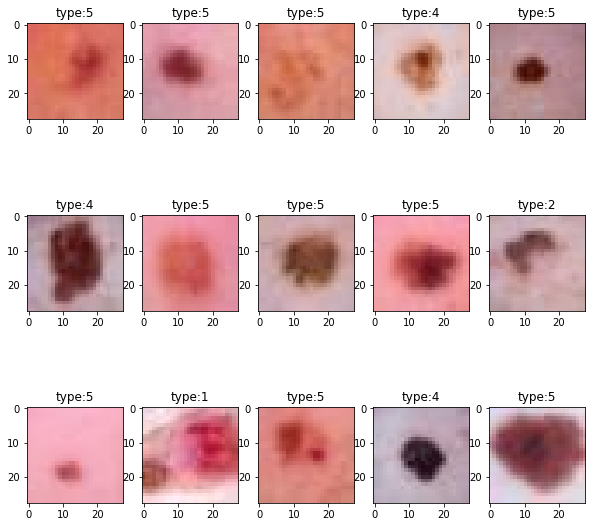

In [3]:
def plot_img(x_train, y_train):
    from matplotlib import pyplot as plt
    fig=plt.figure(figsize=(10, 10))
    columns = 5
    rows = 3
    for i in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, i)
        img = x_train[i]
        plt.imshow(img)
        plt.title('type:'+str(y_train[i][0]))
    plt.show()
plot_img(x_train, y_train)

# Unbalancment of data 

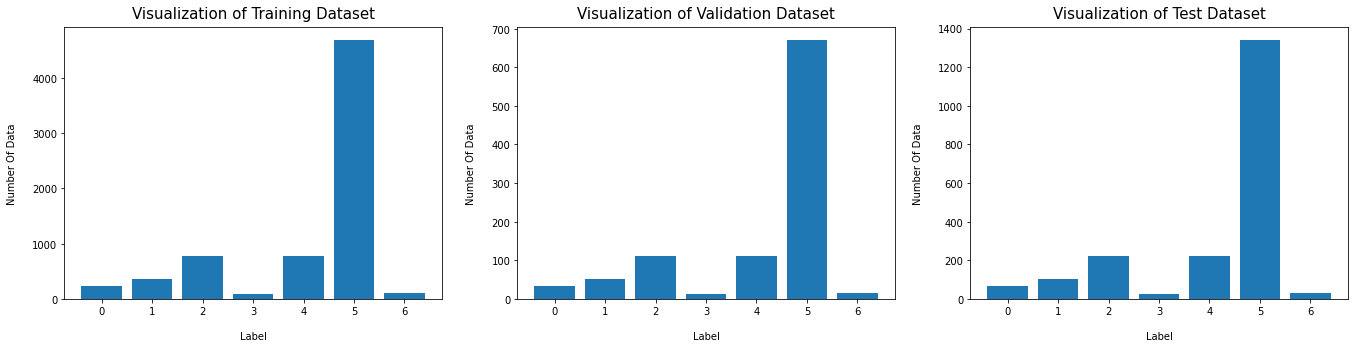

In [4]:
from matplotlib import pyplot as plt

def data_summary(y):
    data = dict()
    for i in range(labels_number):
        data[str(i)] = (int)(np.sum(y==i))
    group_data = list(data.values())
    group_names = list(data.keys())
    return group_data, group_names

def draw_ax(i, group_data, group_names, title):
    ax[i].bar(group_names, group_data)
    ax[i].set_title("Visualization of "+ title , y=1.01, fontsize=15)
    ax[i].set_ylabel("Number Of Data", labelpad=15)
    ax[i].set_xlabel("Label", labelpad=15)

fig, ax = plt.subplots(1, 3, figsize=(23, 5))

group_data, group_names = data_summary(y_train)
draw_ax(0, group_data, group_names, "Training Dataset")

group_data, group_names = data_summary(y_val)
draw_ax(1, group_data, group_names, "Validation Dataset")

group_data, group_names = data_summary(y_test)
draw_ax(2, group_data, group_names, "Test Dataset")

# Preprocess

In [5]:
import tensorflow

x_train = x_train / 255.0
x_val = x_val / 255.0
x_test = x_test / 255.0

y_train = tensorflow.keras.utils.to_categorical(y_train, labels_number)
y_val = tensorflow.keras.utils.to_categorical(y_val, labels_number)
y_test = tensorflow.keras.utils.to_categorical(y_test, labels_number)
print(y_train.shape)
print(x_train.shape)

(7007, 7)
(7007, 28, 28, 3)


# Model && Training

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd

In [7]:
labels = ['akiec',
          'bcc',
          'bkl',
          'df',
          'nv',
          'vasc',
          'mel']

In [8]:
num_classes = []
for i in range(len(labels)):
  num_classes.append(len(np.where(y_train==i)[0]))

pd.DataFrame(num_classes,index=labels)

,0
akiec,42042
bcc,7007
bkl,0
df,0
nv,0
vasc,0
mel,0


In [9]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
                                  rotation_range = 10,
                                  width_shift_range = 0.2,
                                  height_shift_range = 0.2,
                                  shear_range = 0.2,
                                  horizontal_flip = True,
                                  vertical_flip = True,
                                  fill_mode = 'wrap')

batch_size=50
train_data = train_datagen.flow(x_train, y_train, batch_size = batch_size, seed=1)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)
val_data = test_datagen.flow(x_val, y_val, batch_size=batch_size,seed=1)

In [10]:
num_classes = []
for i in range(len(labels)):
  num_classes.append(len(np.where(np.argmax(val_data.y, axis=1)==i)[0]))

pd.DataFrame(num_classes,index=labels)

,0
akiec,33
bcc,52
bkl,110
df,12
nv,111
vasc,671
mel,14


# Model

In [11]:
input_layer = tf.keras.layers.Input(shape=(28,28,3))

# convolution block 1 
cb11 = tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding="same", activation="relu")(input_layer)
cb12 = tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding="same", activation="relu")(cb11)
maxpl1 = tf.keras.layers.MaxPool2D((2,2))(cb12)

#convolution block 2 
cb21 = tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding="same", activation="relu")(maxpl1)
cb22 = tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding="same", activation="relu")(cb21)
maxpl2 = tf.keras.layers.MaxPool2D((2,2))(cb22)

#convolution block 3
cb31 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding="same", activation="relu")(maxpl2)
cb32 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding="same", activation="relu")(cb31)
maxpl3 = tf.keras.layers.MaxPool2D((2,2))(cb32)
x = tf.keras.Model(inputs=input_layer, outputs=maxpl3)

In [12]:
# convolution block 1 
two_cb11 = tf.keras.layers.Conv2D(filters=512, kernel_size=(5,5), strides=(1,1), padding="same", activation="relu")(input_layer)
two_cb12 = tf.keras.layers.Conv2D(filters=512, kernel_size=(5,5), strides=(1,1), padding="same", activation="relu")(two_cb11)
two_maxpl1 = tf.keras.layers.MaxPool2D((2,2))(two_cb12)

#convolution block 2 
two_cb21 = tf.keras.layers.Conv2D(filters=512, kernel_size=(5,5), strides=(1,1), padding="same", activation="relu")(two_maxpl1)
two_cb22 = tf.keras.layers.Conv2D(filters=512, kernel_size=(5,5), strides=(1,1), padding="same", activation="relu")(two_cb21)
two_maxpl2 = tf.keras.layers.MaxPool2D((2,2))(two_cb22)

#convolution block 3
two_cb31 = tf.keras.layers.Conv2D(filters=128, kernel_size=(5,5), strides=(1,1), padding="same", activation="relu")(two_maxpl2)
two_cb32 = tf.keras.layers.Conv2D(filters=128, kernel_size=(5,5), strides=(1,1), padding="same", activation="relu")(two_cb31)
two_maxpl3 = tf.keras.layers.MaxPool2D((2,2))(two_cb32)
y = tf.keras.Model(inputs=input_layer, outputs=two_maxpl3)

In [13]:

combined = tf.keras.layers.concatenate([x.output, y.output])

#convolution block 4
cb41 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding="same", activation="relu")(combined)
cb42 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding="same", activation="relu")(cb41)
cb43 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding="same", activation="relu")(cb42)
maxpl4 = tf.keras.layers.MaxPool2D((2,2))(cb43)

# artificial neural network block
flat   = tf.keras.layers.Flatten()(maxpl4)
dense1 = tf.keras.layers.Dense(1024, activation="relu")(flat)
dense2 = tf.keras.layers.Dense(1024, activation="relu")(dense1)
dense3 = tf.keras.layers.Dense(1024, activation="relu")(dense2)
output = tf.keras.layers.Dense(7, activation="softmax")(dense3)
model = tf.keras.models.Model(inputs=input_layer, outputs=output)

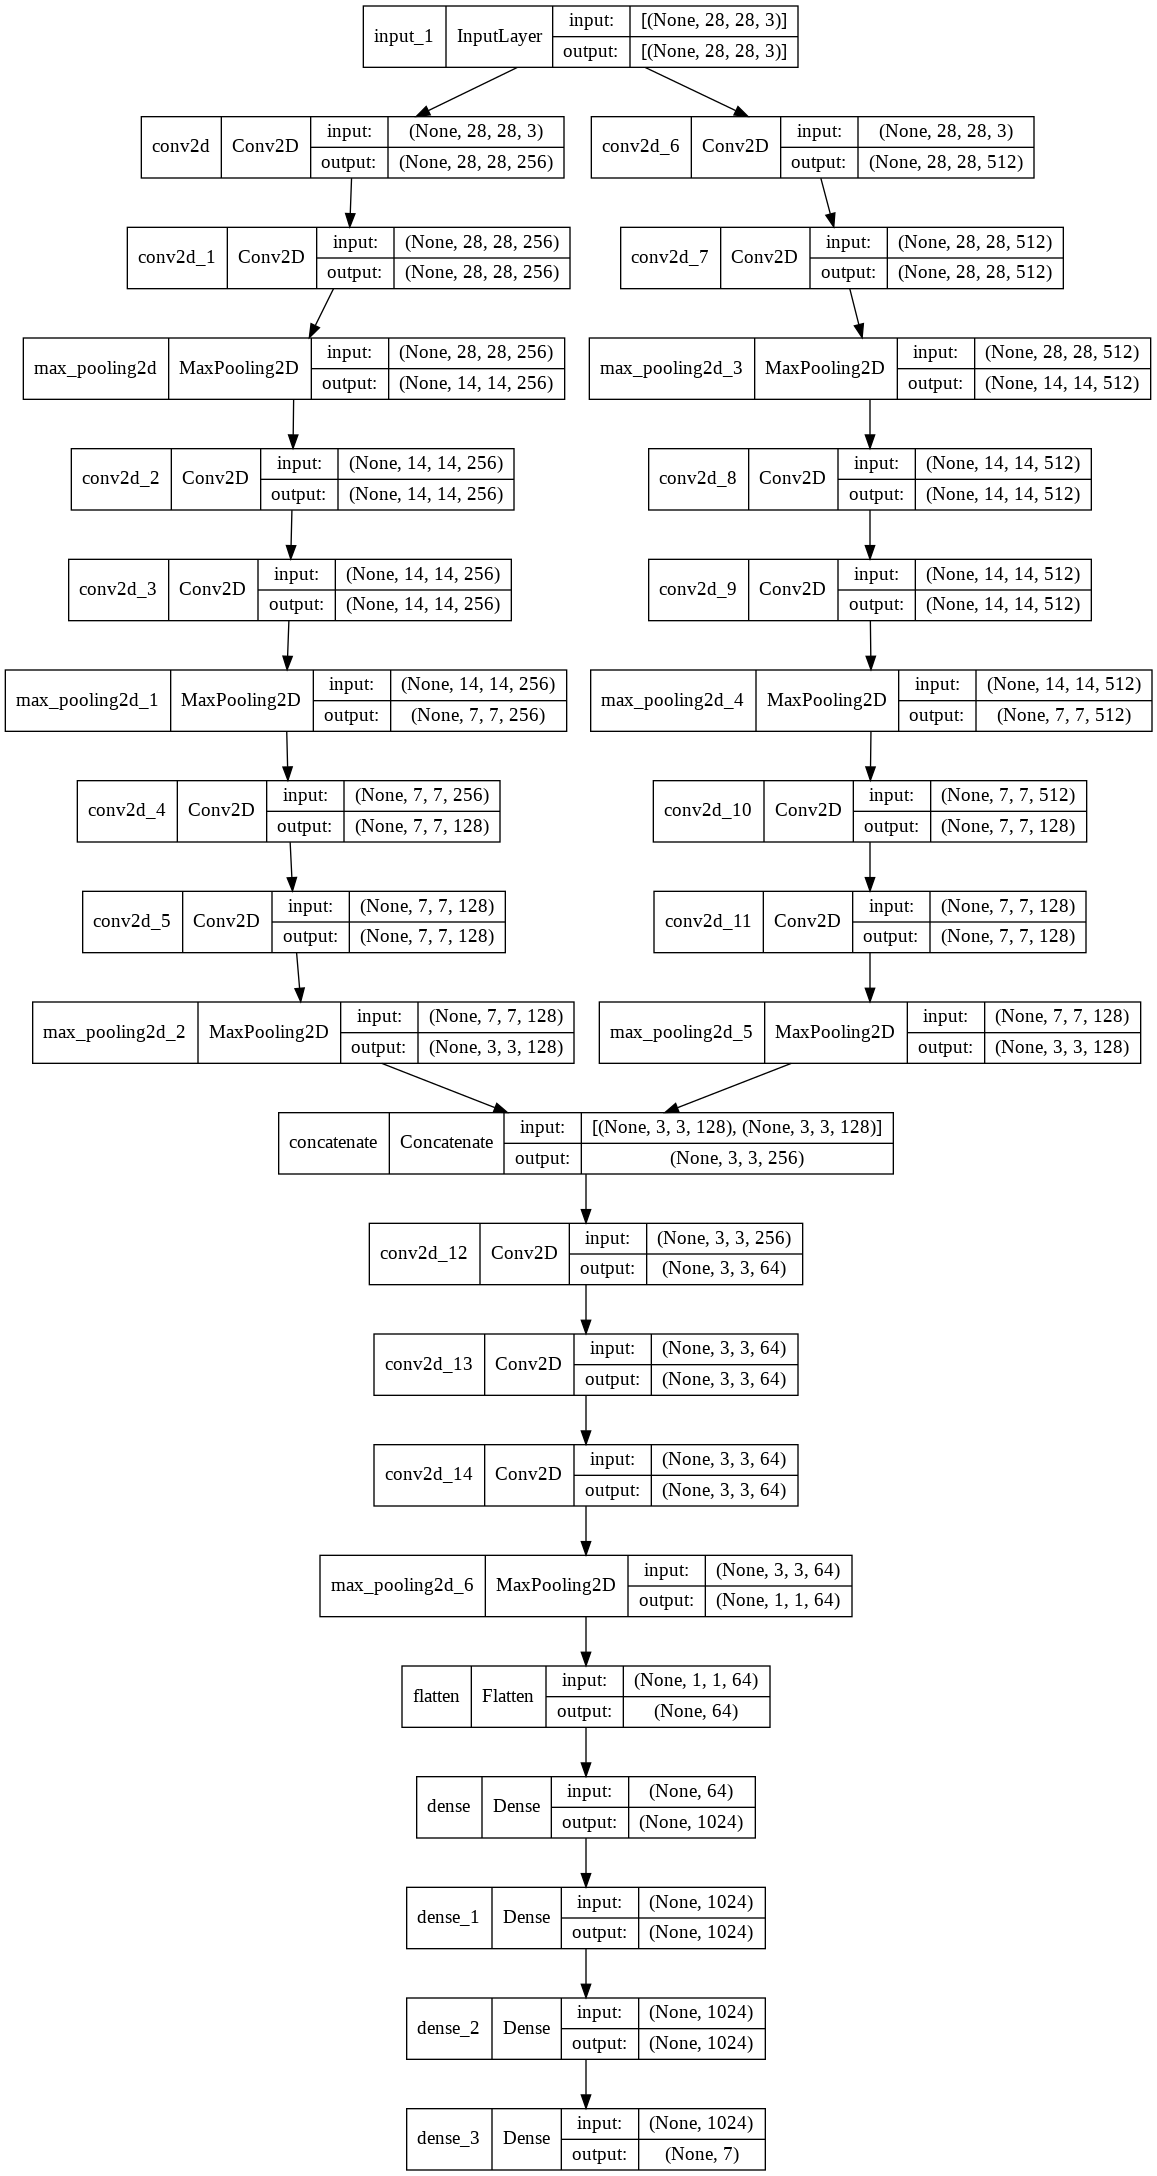

In [14]:
tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [15]:
model.compile(optimizer= tf.keras.optimizers.Adam(0.0001, decay=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [16]:
batch_size = batch_size
epochs = 5
model_history = model.fit(train_data,
                          steps_per_epoch= int(train_data.n/batch_size),
                          epochs=epochs,
                          validation_data=val_data,
                          validation_steps=int(val_data.n/batch_size))

Epoch 1/5
140/140 [==============================] - 48s 202ms/step - loss: 1.2234 - accuracy: 0.6691 - val_loss: 1.1280 - val_accuracy: 0.6680
Epoch 2/5
140/140 [==============================] - 27s 191ms/step - loss: 1.1090 - accuracy: 0.6698 - val_loss: 1.1317 - val_accuracy: 0.6690
Epoch 3/5
140/140 [==============================] - 27s 194ms/step - loss: 1.0751 - accuracy: 0.6694 - val_loss: 1.0780 - val_accuracy: 0.6700
Epoch 4/5
140/140 [==============================] - 28s 198ms/step - loss: 1.0238 - accuracy: 0.6700 - val_loss: 1.0506 - val_accuracy: 0.6680
Epoch 5/5
140/140 [==============================] - 29s 204ms/step - loss: 1.0199 - accuracy: 0.6698 - val_loss: 0.9839 - val_accuracy: 0.6700


In [17]:
model.evaluate(x_test, y_test)

63/63 [==============================] - 8s 73ms/step - loss: 21.7210 - accuracy: 0.6688


[21.721036911010742, 0.6688279509544373]

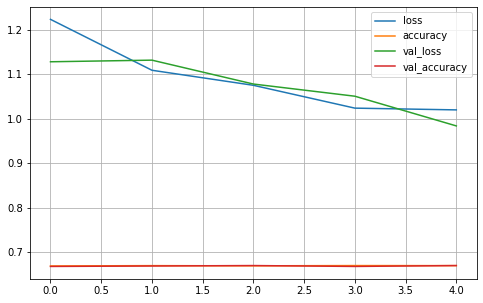

In [18]:
pd.DataFrame(model_history.history).plot(figsize=(8,5))
plt.grid(True)
plt.show()

In [19]:
y_proba = model.predict(x_test)
y_pred = np.argmax(y_proba, axis=-1)

In [20]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc

y_test_numbers = np.array([y.argmax() for y in y_test])

cm = confusion_matrix(y_test_numbers, y_pred)

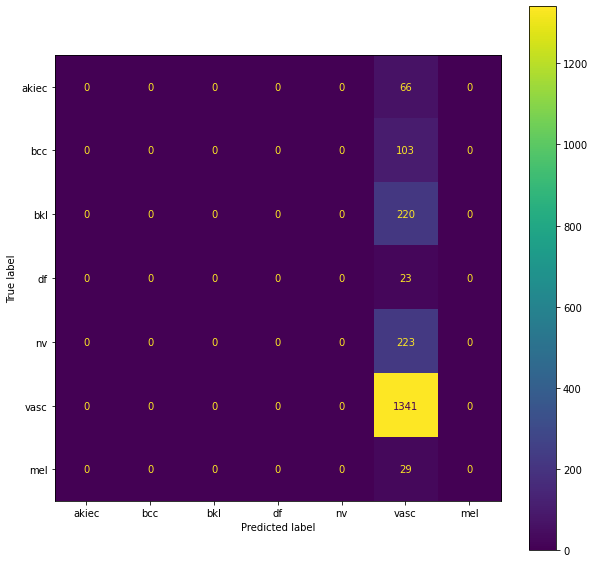

In [21]:
cm_display = ConfusionMatrixDisplay(cm,display_labels=labels)
fig, ax = plt.subplots(figsize=(10,10))
cm_display.plot(ax=ax)

In [22]:
print(classification_report(y_test_numbers, y_pred, target_names = labels))

              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00        66
         bcc       0.00      0.00      0.00       103
         bkl       0.00      0.00      0.00       220
          df       0.00      0.00      0.00        23
          nv       0.00      0.00      0.00       223
        vasc       0.67      1.00      0.80      1341
         mel       0.00      0.00      0.00        29

    accuracy                           0.67      2005
   macro avg       0.10      0.14      0.11      2005
weighted avg       0.45      0.67      0.54      2005



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
lr_probs = model.predict_on_batch(x_test)

In [ ]:
lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
lr_f1, lr_auc = f1_score(testy, yhat), auc(lr_recall, lr_precision)

In [ ]:
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(lr_recall, lr_precision, marker='.', label='Logistic')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()